In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import re
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
import imageio
import os
from IPython.display import Image, display
import time
from scipy.stats import gaussian_kde
from statistics import mean
import statistics
import random

In [2]:
plotdir = 'plots/'

load data


parameters

In [3]:
Ms = 10 #number of importance samples
CHR = 2
tCutoff = 'None'
samples = range(1746*2)
ancestor_loci = [int(i * 51845 / 999) for i in range(1000)]

In [4]:
dispersal = np.loadtxt("data/SGDP_aDNA_new_filtered_chr2_10M_NoneT.sigma", delimiter=',')
dispersal = dispersal.reshape(2, 2)  # 2×2 covariance matrix
print(dispersal)

[[ 9.35515314e-01  2.99832567e+00]
 [-1.32296510e-01  2.33197341e-03]]


In [5]:
# Using only one locus for testing

# Load the .locs file
df = pd.read_csv("data/SGDP_aDNA_new_filtered_chr2_1505locus_10M_NoneT_Alls_Allt.locs", header=None,
                 names=["sample", "time", "lat", "lon"])

# Create index mappings
sample_ids = sorted(df["sample"].unique())
timepoints = sorted(df["time"].unique())

# Initialize and fill anc_locs: shape (1, n, T, 2)
anc_locs = np.full((1, len(sample_ids), len(timepoints), 2), np.nan)

for _, row in df.iterrows():
    s = sample_ids.index(row["sample"])
    t = timepoints.index(row["time"])
    anc_locs[0, s, t, :] = [row["lon"], row["lat"]]

# Shape will be (1, n, T, 2)
print(f"anc_locs shape: {anc_locs.shape}")
L,n,T,d = anc_locs.shape

anc_locs shape: (1, 3492, 10, 2)


In [5]:
#Loading all the loci to get the mean later
pattern = 'data/SGDP_aDNA_new_filtered_chr2_*locus_10M_NoneT_Alls_Allt.locs'

fns = sorted(glob.iglob(pattern))
starts = [int(re.search(r'chr2_(\d+)locus', fn).group(1)) for fn in fns]
locus_order = np.argsort(starts)
fnss_0 = [fns[i] for i in locus_order]
fnss_0.pop(0) # First locus is older version dont want it

# anc_locs_0 = []
# for i,fns in enumerate(fnss_0):
#     anc_loc = np.loadtxt(fns, delimiter=',')
#     anc_locs_0.append(anc_loc)

# anc_locs_0 = np.array(anc_locs_0)
# anc_locs_0 = np.swapaxes(anc_locs_0,0,1)
# L, n, T, d = anc_locs_0.shape
# L, n, T, d 

anc_locs_0 = []
for i, fpath in enumerate(fnss_0):
    df = pd.read_csv(fpath, header=None, names=["sample", "time", "lat", "lon"])
    samples = sorted(df["sample"].unique())
    timepoints = sorted(df["time"].unique())

    n = len(samples)
    T = len(timepoints)

    if n * T != len(df):
        print(f"Skipping {fpath}: expected {n*T} rows but got {len(df)}")
        continue
    sample_map = {v: i for i, v in enumerate(samples)}
    time_map = {v: i for i, v in enumerate(timepoints)}

    # Map samples and times to indices
    s_idx = df["sample"].map(sample_map).values
    t_idx = df["time"].map(time_map).values

    # Pre-allocate array
    arr = np.full((n, T, 2), np.nan)

    # Fill lat/lon efficiently using broadcasting
    arr[s_idx, t_idx, 0] = df["lon"].values
    arr[s_idx, t_idx, 1] = df["lat"].values

    anc_locs_0.append(arr)

anc_locs_0 = np.array(anc_locs_0)  # shape: (L, n, T, 2)
print("Final shape:", anc_locs_0.shape)

anc_locs = anc_locs_0

L, n, T, d = anc_locs.shape
L, n, T, d

Final shape: (939, 3492, 10, 2)


(939, 3492, 10, 2)

In [6]:
ancestor_times = np.logspace(np.log10(4),np.log10(40000),10)
ancestor_times

array([4.00000000e+00, 1.11302376e+01, 3.09705473e+01, 8.61773876e+01,
       2.39793700e+02, 6.67240215e+02, 1.85663553e+03, 5.16619866e+03,
       1.43752547e+04, 4.00000000e+04])

In [8]:
sample_locs = np.loadtxt("data/SGDP_aDNA_new_filtered.locations")
sample_locs= sample_locs[:, [1, 0]] #Flip it so it transforms from lat-lon to lon-lat (same format as anc_locs)

In [9]:
df_poplabels = pd.read_csv("data/SGDP_aDNA_new_filtered_chr2.poplabels", header=None, delim_whitespace=True, skiprows=1,
                            names=["ID", "pop", "group", "sex"])
df_poplabels.drop(columns=["sex"], inplace=True)
df_poplabels.head
                       

/tmp/ipykernel_3205756/2919367699.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_poplabels = pd.read_csv("data/SGDP_aDNA_new_filtered_chr2.poplabels", header=None, delim_whitespace=True, skiprows=1,


<bound method NDFrame.head of                      ID                       pop        group
0     B_Australian-3.DG                Australian      Oceania
1     B_Australian-4.DG                Australian      Oceania
2          B_Crete-1.DG                     Crete  WestEurasia
3          B_Crete-2.DG                     Crete  WestEurasia
4            B_Dai-4.DG                       Dai     EastAsia
...                 ...                       ...          ...
1741             wes056  north_Sweden_Late_Viking       Sweden
1742            Yamnaya                   Yamnaya   Kazakhstan
1743         Yana_young          Yana_Medieval.SG       Russia
1744              Yana1                Yana_UP.SG       Russia
1745              Yana2                Yana_UP.SG       Russia

[1746 rows x 3 columns]>

In [ ]:
#Code to test if locations matches up with poplabels. It does.
fig = plt.figure(figsize=(10, 6), dpi=100)
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree()  # lat/lon
ax = plt.axes(projection=projection)
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')

# Single sample for debug
sample = samples[598]  # change to a value between 0 - 3491 to see a particular sample and its label
pop = df_poplabels["pop"][int(sample/2)] #Since we have each location repeating twice, divide it by 2 to match up with poplabels
group = df_poplabels["group"][int(sample/2)] 
location = sample_locs[sample]
lon, lat = location[0], location[1]

print(f"Sample {int(sample/2)}: lon={lon}, lat={lat} | Pop: {pop}, Group: {group}")

# Plot the point
ax.plot([lon], [lat], marker='o', color='red', markersize=6, transform=data_crs)
ax.text(lon, lat, str(sample), transform=data_crs, fontsize=8,
        ha='left', va='bottom', color='black', weight='bold')

# Show immediately
plt.title(f"Sample {int(sample/2)} - {pop}, {group}")
plt.tight_layout()
plt.show()

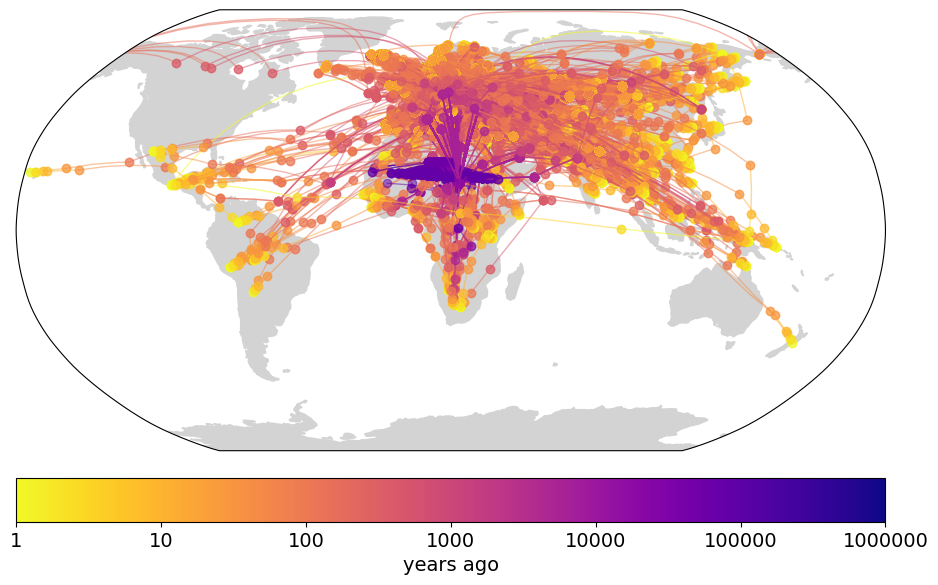

In [48]:
#plotting
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")

for sample in samples: #samples: #for each sample
    # if (sample % 20 != 0):
    #     continue #Skip by 20 to thin num of samples
    #print(sample, "Population", df_poplabels["pop"][sample], " Group ", df_poplabels["group"][sample])
    # get mean ancestor location at all times
    mean_locs = [sample_locs[sample]]
    # time_loc = locations[sample] #start with sample location
    for time_ix in range(T): #exclude late times as numerical issues
        locs = anc_locs[:,sample,time_ix] #locations of all ancestors
        mean_loc = np.mean(locs, axis=0) #mean ancestor location       
        mean_locs.append(mean_loc)
    mean_locs = np.array(mean_locs)


    # plot trajectory of mean ancestor colored by time
    for i in range(len(mean_locs)-1):
        color = cmap(i / len(mean_locs))
        x0,y0 = mean_locs[i, 0], mean_locs[i, 1]
        x1,y1 = mean_locs[i+1, 0], mean_locs[i+1, 1]

        if np.any(np.isnan([x0, y0, x1, y1])):
            continue
        ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=geodetic, marker='o') #great circles
        # ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=data_crs) #straight lines

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(7)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4b.png')
plt.show()

In [10]:
from utils import chop_shared_times
stss = np.loadtxt('data/SGDP_aDNA_new_filtered_chr2_39389locus_10M.stss', delimiter=',') #load in the shared time matrices
print(stss.shape) # shape = MX(NXN)


(10, 6098778)


In [11]:
# for sts in stss:


# load shared time matrix in vector form
#sts = np.fromstring(sts, dtype=float, sep=' ') #convert from string to numpy array
#print(sts)

# chop
#sts = chop_shared_times(sts, T=T) #chop shared times to ignore history beyond T

sts = stss[2] #Just get the shared time matrix for the first importance sample
# convert to matrix form
k = int((np.sqrt(1+8*len(sts))-1)/2) #get size of matrix (from sum_i=0^k i = k(k+1)/2), allows for non-contemporary samples
sts_mat = np.zeros((k,k)) #initialize matrix
sts_mat[np.triu_indices(k, k=0)] = sts #convert to numpy matrix
sts_mat = sts_mat + sts_mat.T - np.diag(np.diag(sts_mat)) #fill in all entries
sts = sts_mat

# sample times
x = np.diag(sts)
x = np.max(x) - x
sample_times = np.sort(x)
print(sample_times) #Each sample time has 3492 columns
# So shape should be 10 X 3492
# locs file has 34920 lines (i.e 10 X 3492)
# So at each time point 

[0.00000000e+00 5.99999839e-06 1.39999975e-05 ... 1.33821007e+03
 1.60786007e+03 1.60786079e+03]


10 3492


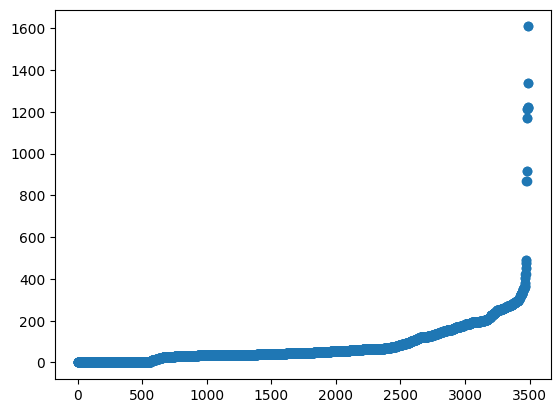

In [12]:
print(len(ancestor_times), len(sample_times))
plt.scatter(range(len(sample_times)), sample_times) #When were samples taken
plt.show()

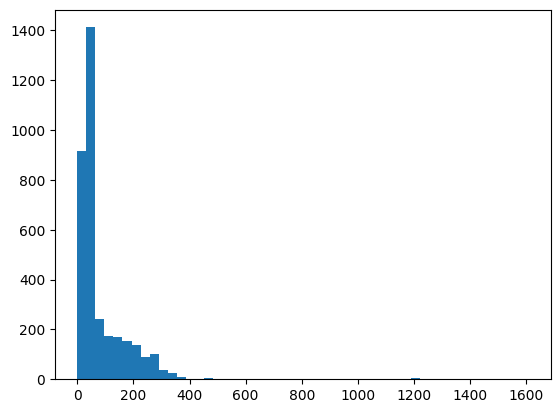

In [69]:
1600

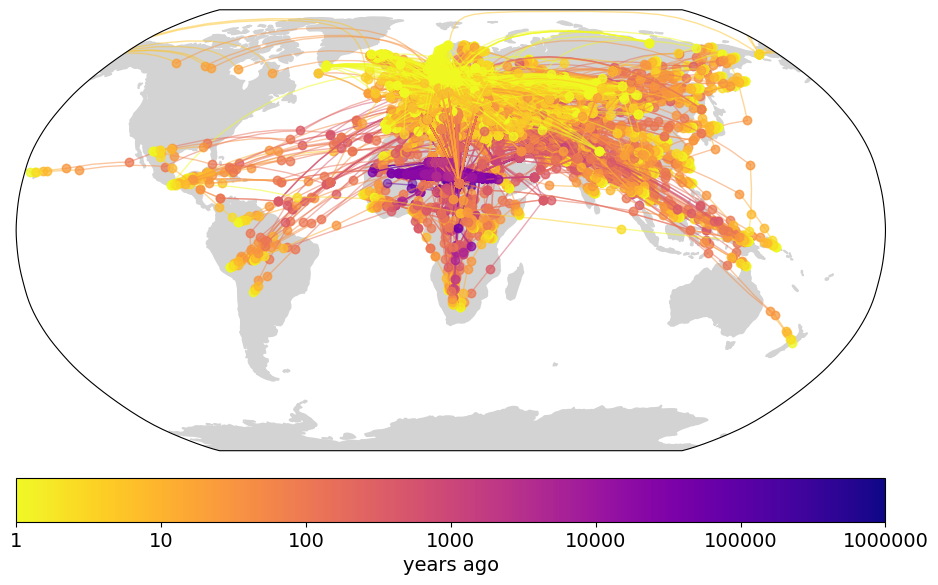

In [26]:
#using old color scale based on len of mean_locs doesnt work well
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")


for sample in samples: #samples: #for each sample

    
    # get mean ancestor location at all times
    mean_locs = [sample_locs[sample]]
    # time_loc = locations[sample] #start with sample location
    sample_time = sample_times[sample]
    for time_ix in range(T): #exclude late times as numerical issues
        if ancestor_times[time_ix] < sample_time:
            print(f'Skipping {sample}')
            continue  # Skip plotting ancestors that existed before the sample
        locs = anc_locs[:,sample,time_ix] #locations of all ancestors
        mean_loc = np.mean(locs, axis=0) #mean ancestor location       
        mean_locs.append(mean_loc)
        
    mean_locs = np.array(mean_locs)

    # plot trajectory of mean ancestor colored by time
    for i in range(len(mean_locs)-1):
        color = cmap(i / len(mean_locs))
        x0,y0 = mean_locs[i, 0], mean_locs[i, 1]
        x1,y1 = mean_locs[i+1, 0], mean_locs[i+1, 1]

        if np.any(np.isnan([x0, y0, x1, y1])):
            continue

        ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=geodetic, marker='o') #great circles
        # # ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=data_crs) #straight lines

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(7)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4b.png')
plt.show()
#print(f'Number of ancient samples: {count_ancients}')

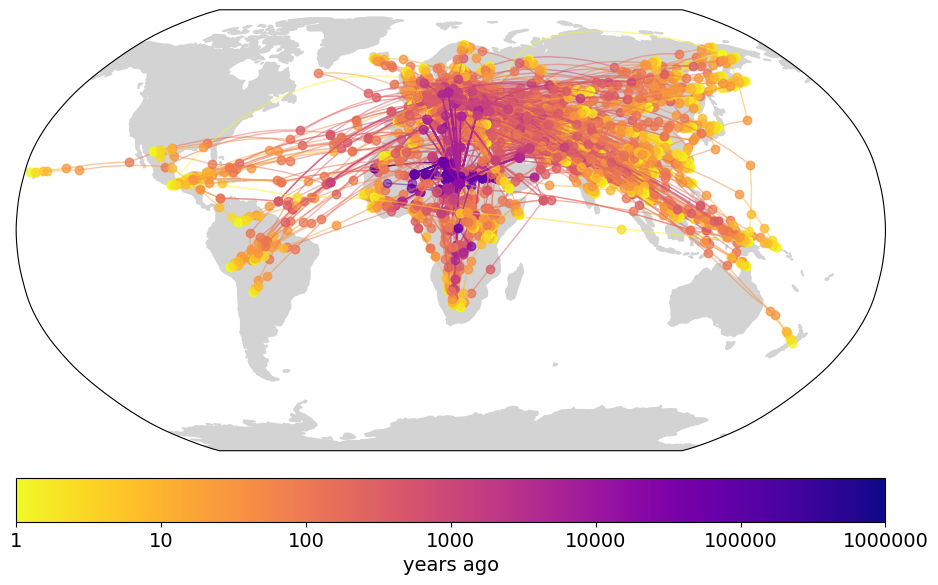

In [69]:
#plotting
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")


for sample in samples: #samples: #for each sample

    
    # get mean ancestor location at all times
    mean_locs = [sample_locs[sample]]
    # time_loc = locations[sample] #start with sample location
    sample_time = sample_times[sample]

    if (sample_time > 0.2): #sampling only contemporary, set to 1 to account for inconsistencies
        continue
    for time_ix in range(T): #exclude late times as numerical issues
        if ancestor_times[time_ix] < sample_time:
            continue  # Skip plotting ancestors that existed before the sample
        locs = anc_locs[:,sample,time_ix] #locations of all ancestors
        mean_loc = np.mean(locs, axis=0) #mean ancestor location       
        mean_locs.append(mean_loc)
        
    mean_locs = np.array(mean_locs)

    # plot trajectory of mean ancestor colored by time
    for i in range(len(mean_locs)-1):
        color = cmap(i / len(mean_locs))
        x0,y0 = mean_locs[i, 0], mean_locs[i, 1]
        x1,y1 = mean_locs[i+1, 0], mean_locs[i+1, 1]

        if np.any(np.isnan([x0, y0, x1, y1])):
            continue

        ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=geodetic, marker='o') #great circles
        # # ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=data_crs) #straight lines

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(7)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4b.png')
plt.show()
#print(f'Number of ancient samples: {count_ancients}')

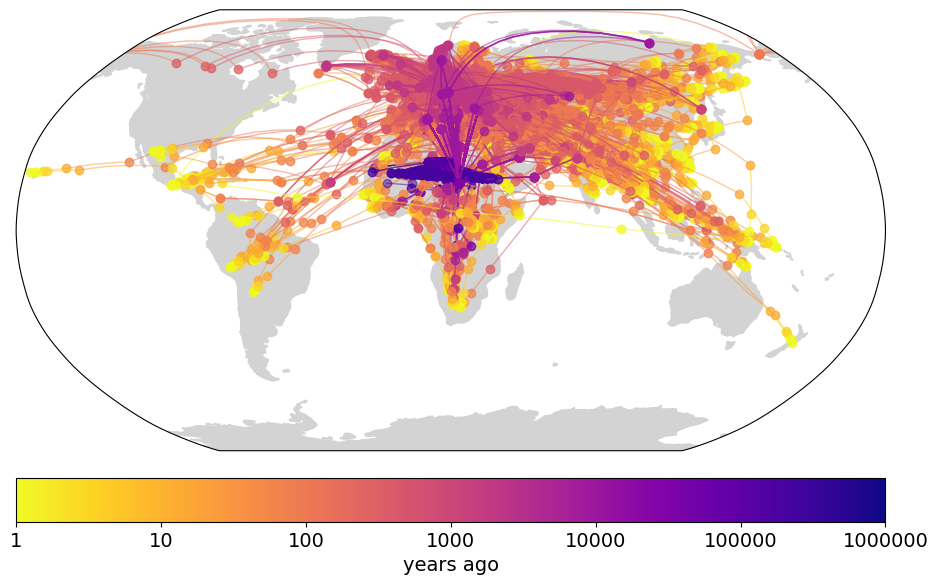

In [70]:
#using a discrete color map with 10 values and mapping to closest color
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")

# Create 10 evenly spaced values between 0 and 1
normalized_values = np.linspace(0, 1, 10)

# Create a color dictionary mapping each time index (0–9) to a color
timepoint_colors = {i: cmap(val) for i, val in enumerate(normalized_values)}

for sample in samples: #samples: #for each sample
    #if (sample != 3000):
        #continue
    # get mean ancestor location at all times
    time_idxs = []  # store when we start collecting samples

    sample_added = False
    mean_locs = []
    sample_time = sample_times[sample]
    

    for time_ix in range(T):
        if ancestor_times[time_ix] < sample_time:
            #time_vals.append(-1)
            #mean_locs.append(-1)
            continue

        if not sample_added:
            mean_locs.append(sample_locs[sample])
            time_idxs.append(time_ix)
            sample_added = True

        locs = anc_locs[:, sample, time_ix]
        mean_loc = np.mean(locs, axis=0)
        mean_locs.append(mean_loc)
        time_idxs.append(time_ix)

    mean_locs = np.array(mean_locs)
    time_vals = np.array(time_vals)

    min_time = np.min(time_vals)
    max_time = np.max(time_vals)

    for i in range(len(mean_locs) - 1):
        # t_norm = (time_vals[i+1] - min_time) / (max_time - min_time)
        # color = cmap(t_norm)
        color = timepoint_colors[time_idxs[i]]

        x0, y0 = mean_locs[i, 0], mean_locs[i, 1]
        x1, y1 = mean_locs[i+1, 0], mean_locs[i+1, 1]

        if np.any(np.isnan([x0, y0, x1, y1])):
            continue

        ax.plot([x0, x1], [y0, y1], color=color, lw=1, alpha=0.5,
                transform=geodetic, marker='o')

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(7)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'discrete_time_scale.png')
plt.show()
#print(f'Number of ancient samples: {count_ancients}')

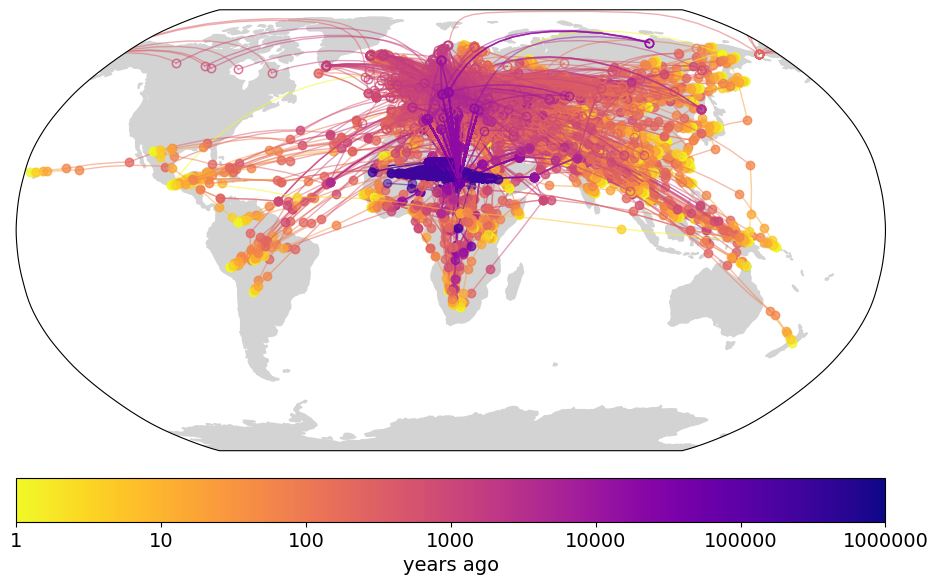

In [110]:
# Using continuous logarithmic color map 
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")
norm = LogNorm(vmin=1, vmax=40005)


for sample in samples: #samples: #for each sample
    #if (sample != 3000):
        #continue
    # get mean ancestor location at all times
    time_vals = []  # store when we start collecting samples

    sample_added = False
    mean_locs = []
    sample_time = sample_times[sample]
    is_ancient = []
    

    for time_ix in range(T):
        if ancestor_times[time_ix] < sample_time:
            #time_vals.append(-1)
            #mean_locs.append(-1)
            is_ancient.append(True)
            continue

        if not sample_added:
            mean_locs.append(sample_locs[sample])
            time_vals.append(sample_time)
            sample_added = True

        locs = anc_locs[:, sample, time_ix]
        mean_loc = np.mean(locs, axis=0)
        mean_locs.append(mean_loc)
        time_vals.append(ancestor_times[time_ix])
        is_ancient.append(False)

    mean_locs = np.array(mean_locs)
    time_vals = np.array(time_vals)

    assert (len(mean_locs) == len(time_vals))
    for i in range(len(mean_locs) - 1):
        # t_norm = (time_vals[i+1] - min_time) / (max_time - min_time)
        # color = cmap(t_norm)
        if time_vals[i] == 0:
            color = 'black'
        else:
            color = cmap(norm(time_vals[i]))

        x0, y0 = mean_locs[i, 0], mean_locs[i, 1]
        x1, y1 = mean_locs[i+1, 0], mean_locs[i+1, 1]

        if np.any(np.isnan([x0, y0, x1, y1])):
            continue

        if (is_ancient[i]):
            ax.plot([x0, x1], [y0, y1], color=color, lw=1, alpha=0.5,
                    transform=geodetic, marker='o', markerfacecolor='none')
        else:
            ax.plot([x0, x1], [y0, y1], color=color, lw=1, alpha=0.5,
                    transform=geodetic, marker='o')

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(7)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'continous_log_time_scale.png')
plt.show()
#print(f'Number of ancient samples: {count_ancients}')

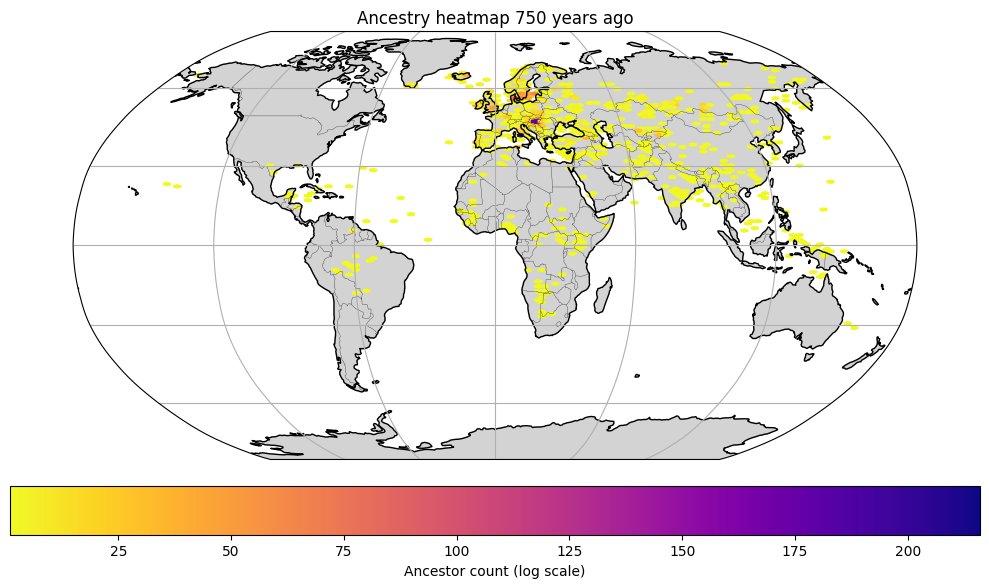

In [108]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Choose a time point
time_ix = 2

# Collect lat/lon from all loci and samples at that time
locs_at_time = anc_locs[:, :, time_ix, :]  # shape: (L, N, 2)
latlon = locs_at_time.reshape(-1, 2)  # shape: (L*N, 2)


# Set up map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.gridlines(draw_labels=False)

# Plot heatmap
hb = ax.hexbin(
    latlon[:, 0],  # longitude
    latlon[:, 1],  # latitude
    gridsize=100,
    transform=ccrs.PlateCarree(),
    cmap='plasma_r',
    mincnt=1
)

cbar = plt.colorbar(hb, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Ancestor count (log scale)')

plt.title(f'Ancestry heatmap {int(ancestor_times[time_ix]) * 25} years ago')
plt.tight_layout()
plt.show()
